In [2]:
import emoji
import os
import pandas as pd
import numpy as np
import re
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore, CoherenceModel
#import pyldavis

import nltk
#nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import spacy

import plotly.graph_objects as go

from collections import Counter

In [1]:
pwd

'/Users/raiha/Documents/EECS-6893-BigData/airline-topic-modeling'

In [2]:
with open("bookmarks_twitter_airlines.txt", "r") as myfile:
    bookmarks = myfile.read().splitlines()
twitter_airline_handles = [bkmk.split("(")[1].split(")")[0] for bkmk in bookmarks]

In [ ]:
# Bucket airlines into continents/regions

region_to_airline_map = {
    'Africa': [],
    
    'United States': [
        'SouthwestAir',
        'united',
        
    ],
    
    'Latin America and Carribean': [
        'AviancaNAM',
        
    ],
    
    'Central/Eastern Asia': [
        'AsianaAirlines', 
    ],
    
    'Southern/South-eastern Asia': [
        'IndonesiaGaruda', 
        'CebuPacificAir',
        'airasia',
        'flyPAL',
        
    ],
    
    'Western Asia': [
        'etihad',
        
    ],
    
    'Europe': [
        'KLM',
        'British_Airways',
        
        
    ],
    
    'Australia and New Zealand': []
    
}

In [2]:
# Combine all dataframes into one dataframe

saved_csvs_dir = "airline_tweets_csvs/"
df_columns = [
    'tweet_id', 
    'user',
    'created_at', 'text', 'is_reply',
    'source', 'lang',
    'retweet_count', 'reply_count', 'like_count', 'quote_count',
    'detected_domain_entity_pairs',
    'annots_found', 'hashtags', 'mentions'
]
full_df = pd.DataFrame(columns=df_columns)

for csv_file_path in os.listdir(saved_csvs_dir):
    print(csv_file_path)
    try:
        new_df = pd.read_csv(saved_csvs_dir + '/' + csv_file_path, low_memory=False)
        full_df = pd.concat([full_df, new_df], axis=0)
    except IsADirectoryError:
        continue
    print(full_df.shape)
    # final shape: (59849, 15)

easyJet.csv.gz
(814, 15)
NokAirlines_ENG.csv.gz
(1602, 15)
GoFirstairways.csv.gz
(2411, 15)
SAS.csv.gz
(3160, 15)
emirates.csv.gz
(3997, 15)
Lufthansa_USA.csv.gz
(4791, 15)
JazeeraAirways.csv.gz
(5218, 15)
VietnamAirlines.csv.gz
(5534, 15)
FlyANA_official.csv.gz
(6377, 15)
wizzair.csv.gz
(7224, 15)
EGYPTAIR.csv.gz
(7942, 15)
MAS.csv.gz
(8738, 15)
JetstarAirways.csv.gz
(9518, 15)
SaudiAirlinesEn.csv.gz
(9661, 15)
Aeroflot_World.csv.gz
(10442, 15)
etihad.csv.gz
(11265, 15)
Jetstar_Asia.csv.gz
(11979, 15)
flyPAL.csv.gz
(12758, 15)
GulfAir.csv.gz
(12891, 15)
CebuPacificAir.csv.gz
(13613, 15)
AeromexicoUSA.csv.gz
(14434, 15)
AerLingus.csv.gz
(15222, 15)
SpiritAirlines.csv.gz
(16046, 15)
flyethiopian.csv.gz
(16846, 15)
AirFranceUK.csv.gz
(17638, 15)
KoreanAir_KE.csv.gz
(18430, 15)
nokairindia.csv.gz
(18582, 15)
AirFranceUS.csv.gz
(19347, 15)
FlyAirNZ.csv.gz
(20117, 15)
AirCanada.csv.gz
(20533, 15)
SingaporeAir.csv.gz
(21335, 15)
tapairportugal.csv.gz
(21704, 15)
volotea.csv.gz
(22249, 15)
Tu

In [3]:
#full_df.to_csv('all_airline_tweets_english.csv.gz', compression='gzip', index=False)

In [35]:
full_df = pd.read_csv('all_airline_tweets_english.csv.gz', low_memory=False)
full_df = full_df.dropna(subset=['user', 'text'])
full_df = full_df[full_df['user'] != '0']

In [36]:
full_df.shape

(57404, 15)

In [37]:
df_user_value_counts = pd.DataFrame(full_df['user'].value_counts())

In [38]:
df_user_value_counts[df_user_value_counts['user'] >= 800].shape

(29, 1)

In [39]:
29 / 85

0.3411764705882353

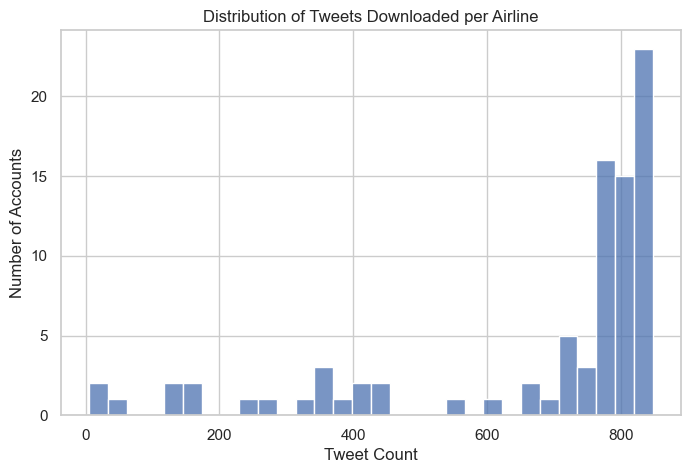

In [40]:
fig = plt.figure(figsize=(8, 5))
sns.histplot(data=df_user_value_counts, x="user", bins=30)
plt.title('Distribution of Tweets Downloaded per Airline')
plt.xlabel('Tweet Count')
plt.ylabel('Number of Accounts')
plt.savefig('tweets_downloaded_per_airline.png')
plt.show()

# At least 700 tweets have been downloaded from 74% of the airline accounts. Generally, 
# any accounts for which less than exactly 800 tweets were downloaded are accounts that do not have more than 800 tweets. 

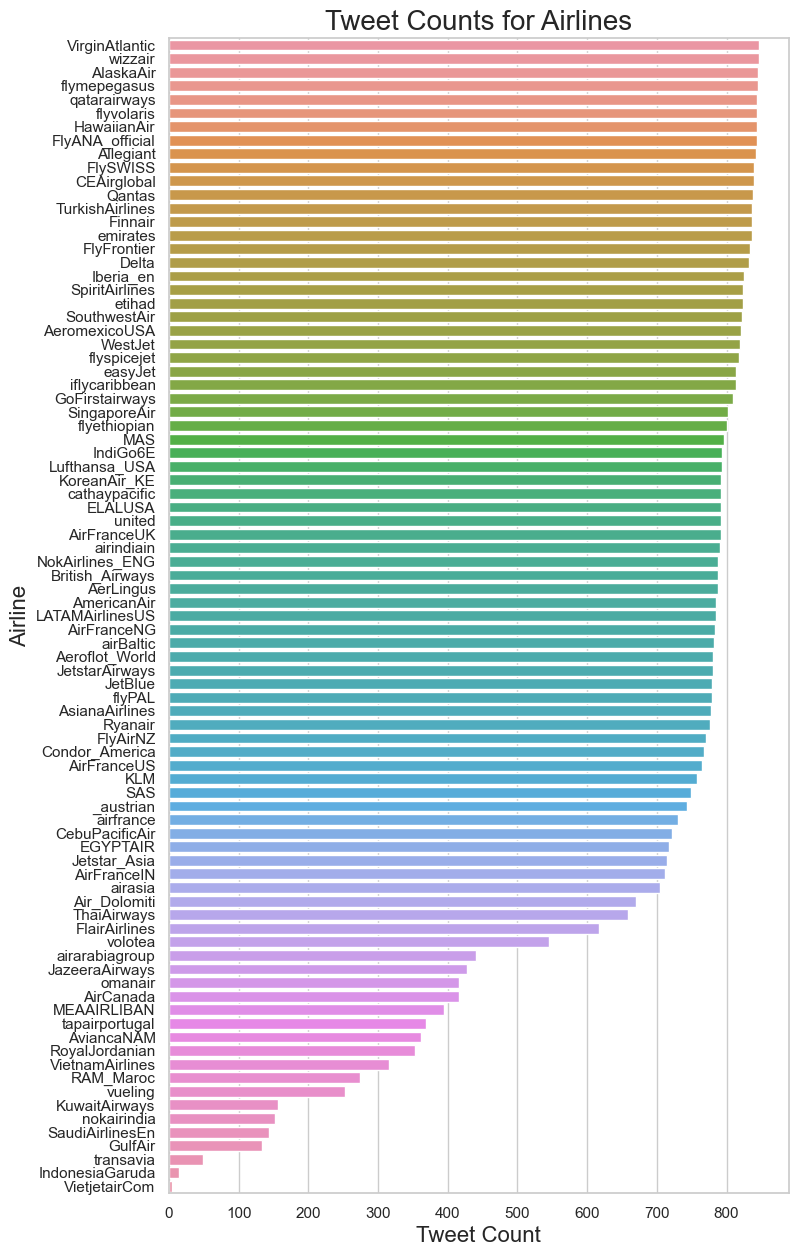

In [41]:
fig = plt.figure(figsize=(8, 15))
sns.countplot(y='user', data=full_df, order=full_df['user'].value_counts().index)

#modify individual font size of elements
plt.xlabel('Tweet Count', fontsize=16);
plt.ylabel('Airline', fontsize=16);
plt.title('Tweet Counts for Airlines', fontsize=20)
# plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('tweet_counts_per_airline.png')
plt.show()


In [42]:
full_df.head()

,tweet_id,user,created_at,text,is_reply,source,lang,retweet_count,reply_count,like_count,quote_count,detected_domain_entity_pairs,annots_found,hashtags,mentions
0,1156918651838054400,easyJet,2019-08-01T13:24:35.000Z,RT @delightdoodahs: Cracking @easyJet flight f...,0.0,Sprinklr,en,3.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",{'Place_Berlin'},{'lettheholidaysbegin'},"{'easyJet', 'EDI_Airport', 'delightdoodahs'}"
1,1156918495462023168,easyJet,2019-08-01T13:23:58.000Z,RT @vfxflyer: Cloud surfing with @easyjet from...,0.0,Sprinklr,en,1.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Unified ...","{'Organization_BSL', 'Other_BUD'}",{'lovetofly'},"{'vfxflyer', 'easyJet'}"
2,1154809777752629249,easyJet,2019-07-26T17:44:41.000Z,RT @LDNLutonAirport: Trains remain severely di...,0.0,Sprinklr,en,2.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",{'Other_Thameslink'},set(),{'LDNLutonAirport'}
3,1154670861376524289,easyJet,2019-07-26T08:32:40.000Z,It may take us a little longer to reply to you...,0.0,Sprinklr,en,2.0,28,11,1,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",NaN,NaN,NaN
4,1154670731613081600,easyJet,2019-07-26T08:32:09.000Z,"Due to adverse weather across the UK, easyJet,...",0.0,Sprinklr,en,6.0,34,31,4,"{'Interests and Hobbies_Air travel', 'Interest...",{'Place_UK'},set(),set()


In [ ]:
# Things to visualize
# 1) Histogram showing number of tweets per user
# 1) Histogram showing counts of tokens per tweet

In [43]:
# I used the following source to discover some common pre-processing steps, 
# and I created my own functions to clean tweets: 
# https://pub.towardsai.net/tweet-topic-modeling-part-2-cleaning-and-preprocessing-tweets-e3a08a8b1770


def clean_tweet(row):
    """Performs removal of emojis, link-related text, 
    retweet-related extra text, and hashtags and mentions.
    Further strips punctuation, extra spaces, and 
    numbers. 
    """
    tweet = row['text']

    
    try:
        # Removing emojis (not in project scope)
        tweet = emoji.replace_emoji(tweet, '')
    

        # Removing link related text
        link_related = [r'http', r'bit.ly/', r'pic.twitter']
        for link_to_clean in link_related:
            tweet = re.sub(fr'{link_to_clean}\S+', '', tweet)
        tweet = tweet.strip("[link]")
        tweet = tweet.replace('&amp;', '&')

        # Removing retweet, mention, or hashtag related text
        rt_mtn_hsh_related = [r'RT\s@', r'@', r'#', r'&amp;']
        for rt_mtn_hsh_to_clean in rt_mtn_hsh_related:
            tweet = re.sub(fr'({rt_mtn_hsh_to_clean}[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

        # Remove punctuation
        punctuation = '!”$%&\’()*+,-./:;<=>?[\\]^_`{|}~•@'
        tweet = re.sub('[' + punctuation + ']+', ' ', tweet)

        # Remove spaces and numbers
        # tweet = re.sub('\s+', ' ', tweet)
        tweet = re.sub('([0-9]+)', '', tweet)
        tweet = tweet.strip()
        
        return tweet
        
    except TypeError:
        print(tweet)
        print(row['user'])
        print(row['tweet_id'])
        return 'CANNOT TRANSFORM'
        
    


def tokenize_and_lemmatize_tweet(row):
    """Returns list of tokens from tweet after lemmatizing. """
    tweet = row['clean_text']
    lemmatizer = WordNetLemmatizer()
    stopwords = gensim.parsing.preprocessing.STOPWORDS
    
    tweet_tokens_lst = []
    tokens = gensim.utils.simple_preprocess(tweet)
    for token in tokens:
        if token not in stopwords and len(token) > 2:
            tweet_tokens_lst.append(lemmatizer.lemmatize(token, pos='v'))
    
    return ' '.join(tweet_tokens_lst)  # tweet


def create_lemma_token_lst(row):
    tokenized_and_lemmatized_tweet = row['tokenize_lemmatize_text']
    return tokenized_and_lemmatized_tweet.split()



In [44]:
full_df['clean_text'] = full_df.apply(lambda row: clean_tweet(row), axis=1)

In [45]:
full_df['tokenize_lemmatize_text'] = full_df.apply(lambda row: tokenize_and_lemmatize_tweet(row), axis=1)

In [46]:
full_df['lemma_tokens'] = full_df.apply(lambda row: create_lemma_token_lst(row), axis=1)

In [47]:
full_df['token_count'] = full_df.apply(lambda row: len(row['lemma_tokens']), axis=1)

In [48]:
full_df.head()

,tweet_id,user,created_at,text,is_reply,source,lang,retweet_count,reply_count,like_count,quote_count,detected_domain_entity_pairs,annots_found,hashtags,mentions,clean_text,tokenize_lemmatize_text,lemma_tokens,token_count
0,1156918651838054400,easyJet,2019-08-01T13:24:35.000Z,RT @delightdoodahs: Cracking @easyJet flight f...,0.0,Sprinklr,en,3.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",{'Place_Berlin'},{'lettheholidaysbegin'},"{'easyJet', 'EDI_Airport', 'delightdoodahs'}",Cracking flight from to Berlin this morning,crack flight berlin morning,"[crack, flight, berlin, morning]",4
1,1156918495462023168,easyJet,2019-08-01T13:23:58.000Z,RT @vfxflyer: Cloud surfing with @easyjet from...,0.0,Sprinklr,en,1.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Unified ...","{'Organization_BSL', 'Other_BUD'}",{'lovetofly'},"{'vfxflyer', 'easyJet'}",Cloud surfing with from BUD to BSL,cloud surf bud bsl,"[cloud, surf, bud, bsl]",4
2,1154809777752629249,easyJet,2019-07-26T17:44:41.000Z,RT @LDNLutonAirport: Trains remain severely di...,0.0,Sprinklr,en,2.0,0,0,0,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",{'Other_Thameslink'},set(),{'LDNLutonAirport'},Trains remain severely disrupted on the Thames...,train remain severely disrupt thameslink line ...,"[train, remain, severely, disrupt, thameslink,...",10
3,1154670861376524289,easyJet,2019-07-26T08:32:40.000Z,It may take us a little longer to reply to you...,0.0,Sprinklr,en,2.0,28,11,1,"{'Interests and Hobbies_Air travel', 'Brand_Ea...",NaN,NaN,NaN,It may take us a little longer to reply to you...,little longer reply volume message currently r...,"[little, longer, reply, volume, message, curre...",11
4,1154670731613081600,easyJet,2019-07-26T08:32:09.000Z,"Due to adverse weather across the UK, easyJet,...",0.0,Sprinklr,en,6.0,34,31,4,"{'Interests and Hobbies_Air travel', 'Interest...",{'Place_UK'},set(),set(),Due to adverse weather across the UK easyJet ...,adverse weather easyjet like airlines expect d...,"[adverse, weather, easyjet, like, airlines, ex...",14


In [49]:
full_df['token_count'].describe()

count    57404.000000
mean        11.426712
std          6.251859
min          0.000000
25%          6.000000
50%         10.000000
75%         16.000000
max         35.000000
Name: token_count, dtype: float64

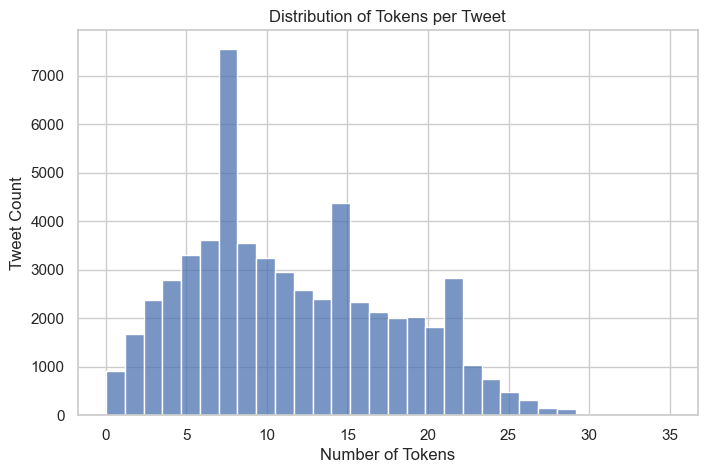

In [50]:
fig = plt.figure(figsize=(8, 5))
sns.histplot(data=full_df, x="token_count", bins=30)
plt.title('Distribution of Tokens per Tweet')
plt.xlabel('Number of Tokens')
plt.ylabel('Tweet Count')
plt.savefig('tokens_per_tweet.png')
plt.show()

# At least 700 tweets have been downloaded from 74% of the airline accounts. Generally, 
# any accounts for which less than exactly 800 tweets were downloaded are accounts that do not have more than 800 tweets. 

### Make Bigrams/Trigrams and Lemmatize

In [51]:
# SOURCE: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel
# Build the bigram and trigram models
data_words = full_df['lemma_tokens'].values.tolist()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [52]:
# Form Bigrams
data_words_bigrams = [bigram_mod[doc] for doc in data_words]

In [53]:
# Form Trigrams
data_words_trigrams = [trigram_mod[bigram_mod[doc]] 
                       for doc in data_words]


In [54]:
data_words[0]

['crack', 'flight', 'berlin', 'morning']

In [55]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [56]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['crack', 'flight', 'morning']]


### Create the Dictionary and Corpus needed for Topic Modeling 

In [57]:
# Create Dictionary
dct = Dictionary(data_lemmatized)
print(len(dct))

18148


In [58]:
# Filtering Extremes
dct.filter_extremes(no_below=2, no_above=.99)
print(len(dct))

9997


In [59]:
# Term Document Frequency using Corpus (data_lemmatized)
corpus = [dct.doc2bow(text) for text in data_lemmatized]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [60]:
# Human readable format of corpus (term-frequency)
[[(dct[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('crack', 1), ('flight', 1), ('morning', 1)]]

In [61]:
# MODEL USED FOR REST OF PROJECT:

lda_model_17 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                               id2word=dct,
                               num_topics=17, 
                               random_state=100,
                               update_every=1,
                               chunksize=100,
                               #passes=10,
                               alpha='auto',
                               per_word_topics=True)

In [120]:
def tune_number_of_topics(data_lemmatized, dct, corpus, start, stop, lda_mdl_type):
    """Method to run LDA modeling with different configurations with
    number of topics and LDA model type (regular, Mallet).
    
    mdl_types = ['lda_regular_no_passes', 'lda_regular_with_passes',
                'lda_mallet_no_passes', 'lda_mallet_with_passes']
    """
    info_to_return = pd.DataFrame()
    
    print('LDA model type:', lda_mdl_type)
    
    for num_topics in range(start, stop+1):
        topics_row = dict()
        
        print("Number of topics:", num_topics)
        topics_row['num_topics'] = num_topics
    
        if 'lda_regular' in lda_mdl_type:
            if lda_mdl_type == 'lda_regular_no_passes':
                lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dct,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               #passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
                

            elif lda_mdl_type == 'lda_regular_with_passes':
                lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dct,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
            
            topics_row['lda_model'] = lda_model
            topics_row['topics'] = lda_model.print_topics()
            for i in lda_model.print_topics():
                print(i)
                print()

            # Compute Perplexity
            perplexity = lda_model.log_perplexity(corpus)
            topics_row['perplexity'] = perplexity
            print('\nPerplexity: ', perplexity)  # a measure of how good the model is. lower the better.

            # Compute Coherence Score
            coherence_model_lda = CoherenceModel(
                model=lda_model, texts=data_lemmatized, dictionary=dct, coherence='u_mass')
            coherence_score = coherence_model_lda.get_coherence()
            topics_row['coherence_umass'] = coherence_score
            print('\nCoherence Score: ', coherence_score)
            
            print()
            print()
            print()
            
        topics_row_df = pd.DataFrame([topics_row])
        info_to_return = pd.concat([info_to_return, topics_row_df], axis=0, ignore_index=True)

    return info_to_return
        
        
    

In [ ]:
df_lda_regular_no_passes = tune_number_of_topics(
    data_lemmatized, dct, corpus, 4, 30, 'lda_regular_no_passes')

In [122]:
df_lda_regular_no_passes

,num_topics,lda_model,topics,perplexity,coherence_umass
0,4,"LdaModel<num_terms=9997, num_topics=4, decay=0...","[(0, 0.036*""world"" + 0.027*""ready"" + 0.021*""ex...",-7.740790,-4.611174
1,5,"LdaModel<num_terms=9997, num_topics=5, decay=0...","[(0, 0.048*""world"" + 0.036*""ready"" + 0.024*""le...",-7.775166,-5.247837
2,6,"LdaModel<num_terms=9997, num_topics=6, decay=0...","[(0, 0.053*""world"" + 0.040*""ready"" + 0.027*""le...",-7.849982,-5.003765
3,7,"LdaModel<num_terms=9997, num_topics=7, decay=0...","[(0, 0.049*""world"" + 0.037*""ready"" + 0.025*""le...",-7.915961,-5.106118
4,8,"LdaModel<num_terms=9997, num_topics=8, decay=0...","[(0, 0.064*""world"" + 0.033*""learn"" + 0.028*""th...",-7.992452,-5.615172
5,9,"LdaModel<num_terms=9997, num_topics=9, decay=0...","[(0, 0.059*""world"" + 0.030*""learn"" + 0.028*""co...",-8.094452,-6.168461
6,10,"LdaModel<num_terms=9997, num_topics=10, decay=...","[(0, 0.064*""world"" + 0.033*""learn"" + 0.031*""co...",-8.244183,-6.070938
7,11,"LdaModel<num_terms=9997, num_topics=11, decay=...","[(0, 0.092*""world"" + 0.069*""ready"" + 0.036*""wa...",-8.482786,-6.171480
8,12,"LdaModel<num_terms=9997, num_topics=12, decay=...","[(0, 0.082*""world"" + 0.061*""ready"" + 0.042*""le...",-8.910187,-6.444452
9,13,"LdaModel<num_terms=9997, num_topics=13, decay=...","[(0, 0.129*""time"" + 0.123*""world"" + 0.048*""wai...",-9.602920,-6.718687


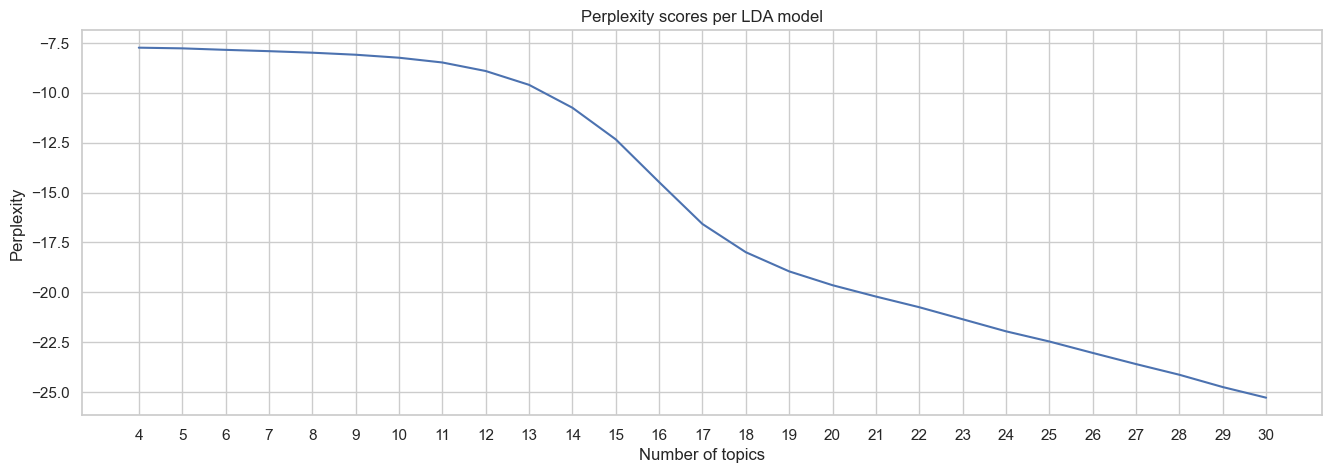

In [248]:
fig = plt.figure(figsize=(16, 5))
sns.lineplot(data=df_lda_regular_no_passes, x="num_topics", y="perplexity").set_xticks(range(4, 31))
plt.title('Perplexity scores per LDA model')
plt.xlabel('Number of topics')
plt.ylabel('Perplexity')
plt.show()

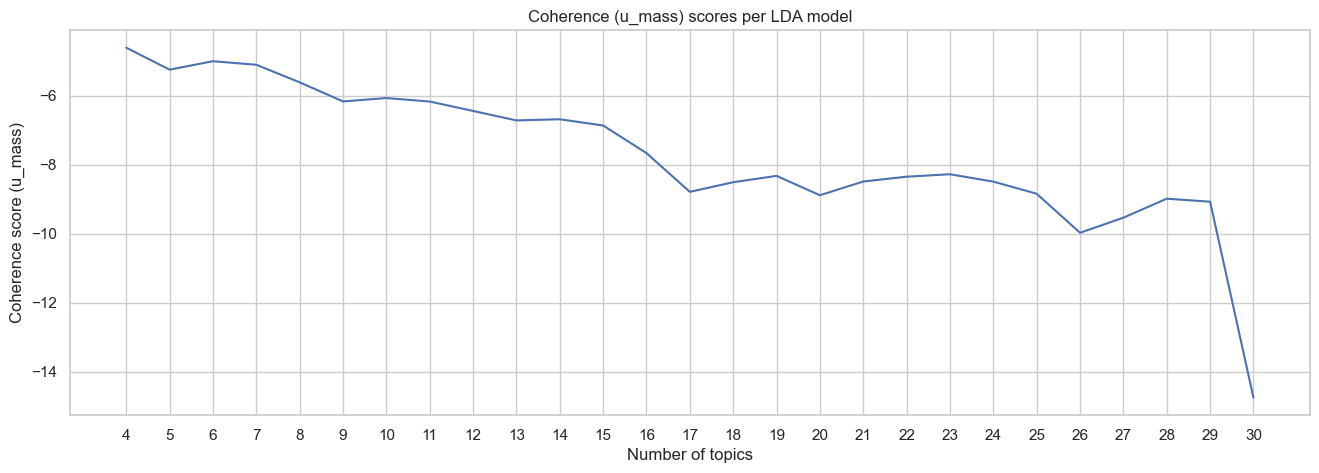

In [125]:
fig = plt.figure(figsize=(16, 5))
sns.lineplot(data=df_lda_regular_no_passes, x="num_topics", y="coherence_umass").set_xticks(range(4, 31))
plt.title('Coherence (u_mass) scores per LDA model')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score (u_mass)')
plt.show()

### Select a number of topics

In [151]:
# num_topics = 8

# min_topic = 4
# loc_index = num_topics - min_topic
# row_num_topics = df_lda_regular_no_passes.loc[loc_index]
# lda_model = row_num_topics['lda_model']

num_topics = 17

min_topic = 4
loc_index = num_topics - min_topic
row_num_topics = df_lda_regular_no_passes.loc[loc_index]
lda_model = row_num_topics['lda_model']

In [141]:
lda_model

### Identify the Dominant topic of each tweet

In [70]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        
                #topics_row_df = pd.DataFrame(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
                sent_topics_df = pd.concat([sent_topics_df,
                                            pd.DataFrame([{'Dominant_Topic': int(topic_num), 
                                             'Perc_Contribution': round(prop_topic,4),
                                             'Topic_Keywords': topic_keywords
                                            }])
                                            # pd.Series([int(topic_num), round(prop_topic,4), topic_keywords])
                                           ], axis=0, ignore_index=True)
            
            else:
                break
                
        
        if i > 0 and i % 5000 == 0:
            #break
            print(i)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

#### num_topics = 8

In [159]:
num_topics = 8

min_topic = 4
loc_index = num_topics - min_topic
row_num_topics = df_lda_regular_no_passes.loc[loc_index]
lda_model_8 = row_num_topics['lda_model']

In [160]:
df_8_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_8, corpus=corpus, texts=data_lemmatized)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [161]:
# Format
df_8_dominant_topic = df_8_topic_sents_keywords.reset_index()
df_8_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_8_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.2312,"flight, fly, check, know, airline, happy, gues...","[crack, flight, morning]"
1,1,6,0.1712,"flight, fly, check, know, airline, happy, gues...",[]
2,2,6,0.1966,"flight, fly, check, know, airline, happy, gues...","[train, remain, severely, disrupt, thameslink,..."
3,3,4,0.3521,"enjoy, experience, area, look, offer, work, gr...","[little, long, reply, volume, message, current..."
4,4,6,0.3846,"flight, fly, check, know, airline, happy, gues...","[adverse_weather, easyjet, airline, expect, di..."
5,5,2,0.2636,"book, travel, time, today, destination, airpor...","[run, moment, time, delay]"
6,6,2,0.3668,"book, travel, time, today, destination, airpor...","[delay, approach, strongly, recommend, custome..."
7,7,2,0.2085,"book, travel, time, today, destination, airpor...","[result, collision, delay, minute, approach, m..."
8,8,6,0.2169,"flight, fly, check, know, airline, happy, gues...","[lane, closure, accident, emergency, service, ..."
9,9,6,0.1891,"flight, fly, check, know, airline, happy, gues...","[thank, great, flight]"


In [162]:
df_8_dominant_topic.sort_values(by='Topic_Perc_Contrib', ascending=False).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
42,42,0,0.4450,"world, learn, thank, food, go, team, support, ...","[big, change, small, change, cabin_crew, colle..."
47073,47073,0,0.4059,"world, learn, thank, food, go, team, support, ...","[deeply, shock, terrorist, attack, thought, vi..."
89,89,4,0.3988,"enjoy, experience, area, look, offer, work, gr...","[look, fun, activity, look, kid, age, share, i..."
12904,12904,6,0.3966,"flight, fly, check, know, airline, happy, gues...","[goahead, settle, ahead, line, board, flight, ..."
49967,49967,6,0.3959,"flight, fly, check, know, airline, happy, gues...","[fly, premium, class, additional, legroom, ext..."


#### num_topics = 17

In [ ]:
num_topics = 17

min_topic = 4
loc_index = num_topics - min_topic
row_num_topics = df_lda_regular_no_passes.loc[loc_index]
lda_model_17 = row_num_topics['lda_model']

In [68]:
from gensim.test.utils import datapath

# # Save model to disk.
temp_file = datapath("/Users/raiha/Documents/EECS-6893-BigData/airline-topic-modeling/lda_model_17")
# lda_model_17.save(temp_file)

# Load a potentially pretrained model from disk.
lda_model_17 = gensim.models.LdaModel.load(temp_file)

In [71]:
df_17_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_17, corpus=corpus, texts=data_lemmatized)

In [72]:
# Format
df_17_dominant_topic = df_17_topic_sents_keywords.reset_index()
df_17_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_17_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9,0.2252,"flight, year, start, celebrate, offer, passeng...","[crack, flight, morning]"
1,1,9,0.1592,"flight, year, start, celebrate, offer, passeng...",[]
2,2,1,0.2936,"city, home, apply, incredible, date, remain, t...","[train, remain, severely, disrupt, thameslink,..."
3,3,3,0.4257,"look, work, great, view, activity, connect, gu...","[little, long, reply, volume, message, current..."
4,4,16,0.3607,"check, experience, airline, trip, discover, ba...","[adverse_weather, easyjet, airline, expect, di..."
5,5,11,0.2784,"time, know, night, beautiful, moment, stay, ho...","[run, moment, time, delay]"
6,6,2,0.2543,"today, excite, journey, fantastic, share, cust...","[delay, approach, strongly, recommend, custome..."
7,7,13,0.4043,"travel, minute, detail, ensure, online, result...","[result, collision, delay, minute, approach, m..."
8,8,5,0.2032,"service, board, ride, nonstop, recovery, guest...","[lane, closure, accident, emergency, service, ..."
9,9,9,0.2053,"flight, year, start, celebrate, offer, passeng...","[thank, great, flight]"


In [165]:
# Format
df_17_dominant_topic = df_17_topic_sents_keywords.reset_index()
df_17_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_17_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9,0.2252,"flight, year, start, celebrate, offer, passeng...","[crack, flight, morning]"
1,1,9,0.1592,"flight, year, start, celebrate, offer, passeng...",[]
2,2,1,0.2936,"city, home, apply, incredible, date, remain, t...","[train, remain, severely, disrupt, thameslink,..."
3,3,3,0.4257,"look, work, great, view, activity, connect, gu...","[little, long, reply, volume, message, current..."
4,4,16,0.3607,"check, experience, airline, trip, discover, ba...","[adverse_weather, easyjet, airline, expect, di..."
5,5,11,0.2784,"time, know, night, beautiful, moment, stay, ho...","[run, moment, time, delay]"
6,6,2,0.2543,"today, excite, journey, fantastic, share, cust...","[delay, approach, strongly, recommend, custome..."
7,7,13,0.4043,"travel, minute, detail, ensure, online, result...","[result, collision, delay, minute, approach, m..."
8,8,5,0.2032,"service, board, ride, nonstop, recovery, guest...","[lane, closure, accident, emergency, service, ..."
9,9,9,0.2053,"flight, year, start, celebrate, offer, passeng...","[thank, great, flight]"


In [168]:
df_17_dominant_topic.sort_values(by='Topic_Perc_Contrib', ascending=False).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
48,48,11,0.5623,"time, know, night, beautiful, moment, stay, ho...","[medieval, hilltop, marvão, beautiful, well, t..."
35863,35863,9,0.5574,"flight, year, start, celebrate, offer, passeng...","[bad_weath, air, traffic_congestion, mumbai_bo..."
42,42,0,0.5572,"world, learn, come, food, team, support, help,...","[big, change, small, change, cabin_crew, colle..."
36274,36274,9,0.5554,"flight, year, start, celebrate, offer, passeng...","[bad_weather, shirdi_sag, departures_arrival, ..."
36257,36257,9,0.5554,"flight, year, start, celebrate, offer, passeng...","[bad_weather, departures_arrival, consequentia..."


#### num_topics = 30

In [208]:
num_topics = 30

min_topic = 4
loc_index = num_topics - min_topic
row_num_topics = df_lda_regular_no_passes.loc[loc_index]
lda_model_30 = row_num_topics['lda_model']

In [212]:
df_30_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_30, corpus=corpus, texts=data_lemmatized)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [213]:
# Format
df_30_dominant_topic = df_30_topic_sents_keywords.reset_index()
df_30_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_30_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,16,0.2055,"flight, airline, continue, board, summer, upda...","[crack, flight, morning]"
1,1,16,0.0976,"flight, airline, continue, board, summer, upda...",[]
2,2,5,0.2731,"bring, week, super, sky, set, remain, town, tr...","[train, remain, severely, disrupt, thameslink,..."
3,3,1,0.5607,"work, long, say, magic, receive, beauty, littl...","[little, long, reply, volume, message, current..."
4,4,16,0.4442,"flight, airline, continue, board, summer, upda...","[adverse_weather, easyjet, airline, expect, di..."
5,5,26,0.2197,"journey, fantastic, moment, head, future, run,...","[run, moment, time, delay]"
6,6,27,0.2759,"fun, activity, traveller, customer, tomorrow, ...","[delay, approach, strongly, recommend, custome..."
7,7,12,0.4826,"minute, participate, present, result, mile, ho...","[result, collision, delay, minute, approach, m..."
8,8,29,0.2736,"service, recovery, close, station, stop, immin...","[lane, closure, accident, emergency, service, ..."
9,9,16,0.1812,"flight, airline, continue, board, summer, upda...","[thank, great, flight]"


In [214]:
df_30_dominant_topic.sort_values(by='Topic_Perc_Contrib', ascending=False).head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
94,94,18,0.6341,"check, look, win, passenger, get, carry, info,...","[look, kid, age, share, idea, plane, future, f..."
89,89,18,0.5939,"check, look, win, passenger, get, carry, info,...","[look, fun, activity, look, kid, age, share, i..."
69,69,22,0.5825,"fly, read, month, life, history, schedule, cat...","[wonder, fly, plane, black, history, month, ca..."
3,3,1,0.5607,"work, long, say, magic, receive, beauty, littl...","[little, long, reply, volume, message, current..."
86,86,5,0.5230,"bring, week, super, sky, set, remain, town, tr...","[ready, week, week, bring, good, cinematic, es..."


#### Distribution of Dominant topics for different numbers of topics

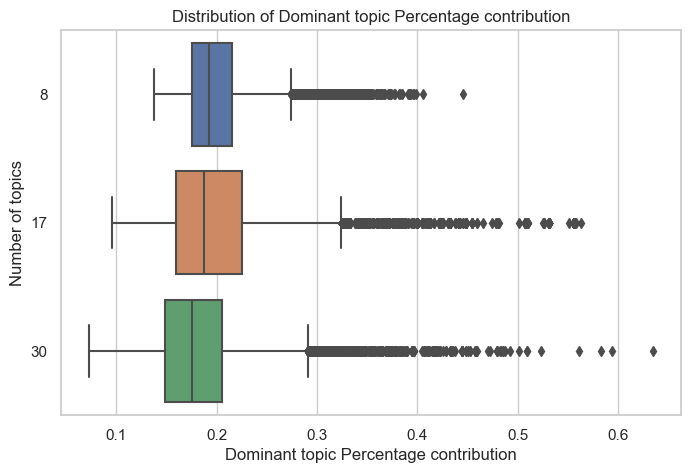

In [218]:
df_8_dominant_topic['num_topics'] = '8'
df_17_dominant_topic['num_topics'] = '17'
df_30_dominant_topic['num_topics'] = '30'
df_8_17_30_dominant_topic = pd.concat([df_8_dominant_topic, df_17_dominant_topic, df_30_dominant_topic], axis=0, ignore_index=True)

# plt.figure(figsize=(8, 5))
# sns.histplot(data=df_8_17_30_dominant_topic, x="Topic_Perc_Contrib", hue="num_topics")
# plt.title('Distribution of Dominant topic Percentage contribution')
# plt.xlabel('Dominant topic Percentage contribution')
# plt.ylabel('Tweet count')
# plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_8_17_30_dominant_topic, x="Topic_Perc_Contrib", y="num_topics")
plt.title('Distribution of Dominant topic Percentage contribution')
plt.xlabel('Dominant topic Percentage contribution')
plt.ylabel('Number of topics')
plt.show()

### Find the tweet that best represents a topic

#### num_topics = 30

In [219]:
df_30_tweets_best_rep_topic = pd.DataFrame()

for topic_num in range(30):
    df_30_tweets_best_rep_topic = pd.concat(
        [df_30_tweets_best_rep_topic, 
         df_30_dominant_topic[df_30_dominant_topic['Dominant_Topic'] == topic_num].sort_values(by='Topic_Perc_Contrib', ascending=False).head(10)
    ], axis=0, ignore_index=True)

In [220]:
def get_dominant_topic_tweets(topic_num):
    sub_df = df_30_tweets_best_rep_topic[df_30_tweets_best_rep_topic['Dominant_Topic'] == topic_num]
    print('Keywords:')
    print(sub_df['Keywords'].values[0])
    print()
    print('Tweet clean text:')
    print(sub_df[['Document_No', 'Text']].values)
    print()
    print('Tweets:')
    for idx in sub_df['Document_No'].values:
        print(full_df.loc[idx]['text'])
        print()

In [222]:
# get_dominant_topic_tweets(0)
# Campaigns related to charitable work, raising awareness

get_dominant_topic_tweets(1)

Keywords:
work, long, say, magic, receive, beauty, little, finally, currently, patience

Tweet clean text:
[[3
  list(['little', 'long', 'reply', 'volume', 'message', 'currently', 'receive', 'work', 'quickly', 'thank', 'patience'])]
 [6094
  list(['receive', 'index', 'award', 'encourage', 'company', 'create', 'lgbtq', 'friendly', 'workplace', 'diversity_inclusion', 'long', 'priority', 'ana', 'honor', 'receive', 'recognition'])]
 [56264
  list(['work', 'home', 'work', 'beach', 'check', 'remote', 'work', 'space', 'work', 'life', 'breezy'])]
 [45261
  list(['inform', 'web', 'check', 'disable', 'disregard', 'error', 'message', 'generate', 'currently', 'work', 'remove', 'page'])]
 [80 list(['finally', 'cinematic', 'magic', 'european', 'city'])]
 [28580
  list(['long', 'work', 'plan', 'need', 'long', 'weekend', 'getaway', 'book', 'perfect', 'long', 'trip', 'today', 'eholiday'])]
 [11795
  list(['merry_christma', 'happy', 'enjoy', 'festive', 'long', 'long', 'long', 'weekend'])]
 [19422
  list

#### num_topics = 17

In [281]:
df_17_tweets_best_rep_topic = pd.DataFrame()

for topic_num in range(17):
    df_17_tweets_best_rep_topic = pd.concat(
        [df_17_tweets_best_rep_topic, 
         df_17_dominant_topic[df_17_dominant_topic['Dominant_Topic'] == topic_num].sort_values(by='Topic_Perc_Contrib', ascending=False).head(20)
    ], axis=0, ignore_index=True)

In [295]:
# full_df.loc[16861].text

In [294]:
# df_17_dominant_topic[df_17_dominant_topic['Dominant_Topic'] == 13].sort_values(by='Topic_Perc_Contrib', ascending=False).reset_index().iloc[150:200, :]

In [282]:
def get_dominant_topic_tweets(topic_num):
    sub_df = df_17_tweets_best_rep_topic[df_17_tweets_best_rep_topic['Dominant_Topic'] == topic_num]
    print('Keywords:')
    print(sub_df['Keywords'].values[0])
    print()
    print('Tweet clean text:')
    print(sub_df[['Document_No', 'Text']].values)
    print()
    print('Tweets:')
    for idx in sub_df['Document_No'].values:
        print(full_df.loc[idx]['text'])
        print()

In [293]:
# get_dominant_topic_tweets(0)
# Charitable work, raising awareness
####

# get_dominant_topic_tweets(1)

# get_dominant_topic_tweets(2)
# Future-forward campaigns (i.e. aviation, sustainability)
####

# get_dominant_topic_tweets(3)
# Best views
####

# get_dominant_topic_tweets(4)
# Participate in a contest (use a hashtag and tag three friends)
####

# get_dominant_topic_tweets(5)
# non-stop service
####

# get_dominant_topic_tweets(6)
# Promotional campaign via travel suggestions
####

# get_dominant_topic_tweets(7)

# get_dominant_topic_tweets(8)
# Best fares or low fares or discounted fares
####

# get_dominant_topic_tweets(9)
# Bad weather updates, but other things too

# get_dominant_topic_tweets(10)
# Airline growth (new routes, aircraft, offerings)
####

# get_dominant_topic_tweets(11)
# Scenic/peaceful travel destinations
####

# get_dominant_topic_tweets(12)
# Flight seating (group seating, upgrades)
####

# get_dominant_topic_tweets(13)
# Travel alerts and advisories
####

# get_dominant_topic_tweets(14)
# For more info related to flight or opportunities, please visit our website
####

# get_dominant_topic_tweets(15)

# get_dominant_topic_tweets(16)
# Checking in, anything related to having a comfortable traveler experience
####

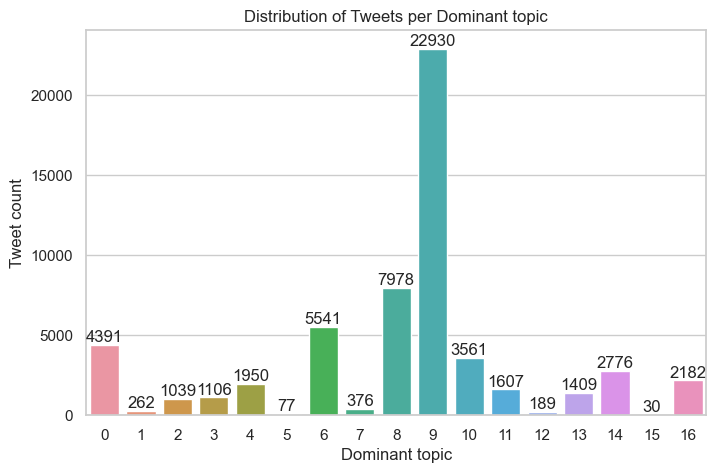

In [256]:
# Determine the share of tweets per topic

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Dominant_Topic', data=df_17_dominant_topic)
ax.bar_label(ax.containers[0])
plt.title('Distribution of Tweets per Dominant topic')
plt.xlabel('Dominant topic')
plt.ylabel('Tweet count')
plt.show()

# topics we are picking to show (total: 13):
# 0, 2-6, 8, 10-13, 14, 16

# topics where tweets do not seem to share a common theme (total: 4):
# 1, 7, 9, 15

In [306]:
full_df_reset_idx = full_df.reset_index().drop('index', axis=1)

In [308]:
merged_output_df = pd.merge(full_df_reset_idx, df_17_dominant_topic, left_index=True, right_index=True)

In [309]:
merged_output_df.shape

(57404, 26)

## Heatmap showing Topic contributions to Airline tweets

In [3]:
#merged_output_df.to_csv('tweets_17_topics_all_info.csv', index=False)
merged_output_df = pd.read_csv('tweets_17_topics_all_info.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'tweets_17_topics_all_info.csv'

In [75]:
merged_output_df.head()

,tweet_id,user,created_at,text,is_reply,source,lang,retweet_count,reply_count,like_count,...,tokenize_lemmatize_text,lemma_tokens,token_count,contains_amp,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,num_topics
0,1156918651838054400,easyJet,2019-08-01T13:24:35.000Z,RT @delightdoodahs: Cracking @easyJet flight f...,0.0,Sprinklr,en,3.0,0.0,0.0,...,crack flight berlin morning,"['crack', 'flight', 'berlin', 'morning']",4,0,0,9,0.2252,"flight, year, start, celebrate, offer, passeng...","['crack', 'flight', 'morning']",17
1,1156918495462023168,easyJet,2019-08-01T13:23:58.000Z,RT @vfxflyer: Cloud surfing with @easyjet from...,0.0,Sprinklr,en,1.0,0.0,0.0,...,cloud surf bud bsl,"['cloud', 'surf', 'bud', 'bsl']",4,0,1,9,0.1592,"flight, year, start, celebrate, offer, passeng...",[],17
2,1154809777752629249,easyJet,2019-07-26T17:44:41.000Z,RT @LDNLutonAirport: Trains remain severely di...,0.0,Sprinklr,en,2.0,0.0,0.0,...,train remain severely disrupt thameslink line ...,"['train', 'remain', 'severely', 'disrupt', 'th...",10,0,2,1,0.2936,"city, home, apply, incredible, date, remain, t...","['train', 'remain', 'severely', 'disrupt', 'th...",17
3,1154670861376524289,easyJet,2019-07-26T08:32:40.000Z,It may take us a little longer to reply to you...,0.0,Sprinklr,en,2.0,28.0,11.0,...,little longer reply volume message currently r...,"['little', 'longer', 'reply', 'volume', 'messa...",11,0,3,3,0.4257,"look, work, great, view, activity, connect, gu...","['little', 'long', 'reply', 'volume', 'message...",17
4,1154670731613081600,easyJet,2019-07-26T08:32:09.000Z,"Due to adverse weather across the UK, easyJet,...",0.0,Sprinklr,en,6.0,34.0,31.0,...,adverse weather easyjet like airlines expect d...,"['adverse', 'weather', 'easyjet', 'like', 'air...",14,0,4,16,0.3607,"check, experience, airline, trip, discover, ba...","['adverse_weather', 'easyjet', 'airline', 'exp...",17


In [7]:
merged_output_df.shape

(57404, 26)

In [8]:
# Remove topics we want to exclude from analysis
# 1, 7, 9, 15

merged_output_df2 = merged_output_df[~merged_output_df.Dominant_Topic.isin([1, 7, 9, 15])]
merged_output_df2.shape

(33806, 26)

In [9]:
user_tweet_counts = merged_output_df2.groupby(['user'])['Document_No'].count().reset_index().rename(columns={'Document_No': 'tweet_count'})
user_topic_tweet_counts = merged_output_df2.groupby([
    'user', 'Dominant_Topic'])['Document_No'].count().reset_index().rename(columns={'Document_No': 'topic_tweet_count'})

In [10]:
user_tweet_counts_ALL = pd.merge(user_tweet_counts, user_topic_tweet_counts, how='left', on='user')

In [11]:
user_tweet_counts_ALL['topic_pct'] = user_tweet_counts_ALL['topic_tweet_count'] / user_tweet_counts_ALL['tweet_count']

In [12]:
user_tweet_counts_ALL['topic_pct'].sum()

85.0

In [345]:
# user_tweet_counts['user'].tolist()

In [13]:
user_tweet_counts_ALL.head(5)

,user,tweet_count,Dominant_Topic,topic_tweet_count,topic_pct
0,AerLingus,450,0,47,0.104444
1,AerLingus,450,2,26,0.057778
2,AerLingus,450,3,18,0.040000
3,AerLingus,450,4,21,0.046667
4,AerLingus,450,5,1,0.002222


In [16]:
all_airlines = user_tweet_counts['user'].tolist()
# all_columns = ['topic_num'] + all_airlines
all_columns = all_airlines
all_topic_nums = user_tweet_counts_ALL['Dominant_Topic'].unique()
df_heatmap_topic_lvl_airline_scores = pd.DataFrame(columns=all_columns)

for topic_num in all_topic_nums:
    topic_num_pcts = user_tweet_counts_ALL[user_tweet_counts_ALL['Dominant_Topic']==topic_num]['topic_pct'].tolist()

    new_row_dict = {airline: topic_pct for airline, topic_pct in zip(all_airlines, topic_num_pcts)}

    new_row_df = pd.DataFrame(new_row_dict, index=[topic_num])

    df_heatmap_topic_lvl_airline_scores = pd.concat([df_heatmap_topic_lvl_airline_scores, new_row_df], axis=0, ignore_index=False)
    
df_heatmap_topic_lvl_airline_scores.fillna(0, inplace=True)

In [17]:
df_heatmap_topic_lvl_airline_scores

,AerLingus,Aeroflot_World,AeromexicoUSA,AirCanada,AirFranceIN,AirFranceNG,AirFranceUK,AirFranceUS,Air_Dolomiti,AlaskaAir,...,iflycaribbean,nokairindia,omanair,qatarairways,tapairportugal,transavia,united,volotea,vueling,wizzair
0,0.104444,0.111111,0.194831,0.142857,0.054230,0.072874,0.078846,0.130178,0.108491,0.147170,...,0.015385,0.068000,0.161017,0.127551,0.111111,0.169197,0.141914,0.063158,0.056452,0
2,0.057778,0.006006,0.019881,0.003322,0.013015,0.010121,0.032692,0.017751,0.028302,0.022642,...,0.028000,0.035593,0.025510,0.036876,0.013201,0.031579,0.008065,0.000000,0.000000,0
3,0.040000,0.015015,0.007952,0.016611,0.060738,0.022267,0.026923,0.039448,0.037736,0.030189,...,0.148148,0.041215,0.026403,0.031579,0.020968,0.000000,0.000000,0.000000,0.000000,0
4,0.046667,0.039039,0.027833,0.036545,0.169197,0.070850,0.103846,0.071006,0.037736,0.050943,...,0.076923,0.032000,0.040678,0.035714,0.037037,0.049892,0.029703,0.031579,0.019355,0
5,0.002222,0.003839,0.002079,0.004090,0.007282,0.001898,0.002387,0.004073,0.002770,0.001912,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
6,0.171111,0.171171,0.192843,0.073090,0.203905,0.216599,0.203846,0.157791,0.195755,0.150943,...,0.153846,0.108000,0.237288,0.112245,0.148148,0.214751,0.211221,0.021053,0.074194,0
8,0.146667,0.219219,0.155070,0.063123,0.221258,0.263158,0.161538,0.228797,0.200472,0.309434,...,0.400000,0.380000,0.225424,0.357143,0.111111,0.143167,0.171617,0.052632,0.574194,0
10,0.142222,0.108108,0.238569,0.053156,0.106291,0.123482,0.159615,0.126233,0.115566,0.105660,...,0.052000,0.081356,0.076531,0.074074,0.127983,0.214521,0.557895,0.124194,0.000000,0
11,0.057778,0.048048,0.033797,0.029900,0.032538,0.036437,0.055769,0.047337,0.061321,0.030189,...,0.048000,0.035593,0.035714,0.037037,0.043384,0.049505,0.030645,0.000000,0.000000,0
12,0.004444,0.001988,0.003322,0.002024,0.003945,0.018868,0.001887,0.007678,0.008316,0.006110,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [25]:
topic_nums_to_names = {
    "0": "Charitable work, raising awareness",
    "2": "Future-forward campaigns (i.e. aviation, sustainability)",
    "3": "Travel spots with the best views",
    "4": "Campaign with a contest",
    "5": "Non-stop flight service",
    "6": "Promotional campaign via travel suggestions",
    "8": "Best/lowest/discounted fares",
    "10": "Airline growth (i.e. new routes, aircraft, offerings)",
    "11": "Scenic/peaceful travel destinations",
    "12": "Flight seating (i.e. group seating, upgrades)",
    "13": "Travel alerts and advisories",
    "14": "Visit our website for more info",
    "16": "Tips for comfortable travel experience"
}

In [29]:
df_heatmap_topic_lvl_airline_scores.T.loc[::-1, :]

,0,2,3,4,5,6,8,10,11,12,13,14,16
wizzair,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vueling,0.056452,0.000000,0.000000,0.019355,0.000000,0.074194,0.574194,0.000000,0.000000,0.000000,0.000000,0.032258,0.037097
volotea,0.063158,0.000000,0.000000,0.031579,0.000000,0.021053,0.052632,0.124194,0.000000,0.000000,0.019355,0.073684,0.042105
united,0.141914,0.008065,0.000000,0.029703,0.000000,0.211221,0.171617,0.557895,0.030645,0.000000,0.094737,0.039604,0.079208
transavia,0.169197,0.031579,0.000000,0.049892,0.000000,0.214751,0.143167,0.214521,0.049505,0.000000,0.013201,0.073753,0.041215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
AirFranceIN,0.054230,0.013015,0.060738,0.169197,0.007282,0.203905,0.221258,0.106291,0.032538,0.003945,0.023861,0.082430,0.032538
AirCanada,0.142857,0.003322,0.016611,0.036545,0.004090,0.073090,0.063123,0.053156,0.029900,0.002024,0.518272,0.023256,0.036545
AeromexicoUSA,0.194831,0.019881,0.007952,0.027833,0.002079,0.192843,0.155070,0.238569,0.033797,0.003322,0.015905,0.035785,0.075547
Aeroflot_World,0.111111,0.006006,0.015015,0.039039,0.003839,0.171171,0.219219,0.108108,0.048048,0.001988,0.021021,0.180180,0.081081


In [76]:
fig = go.Figure(data=go.Heatmap(
        z=df_heatmap_topic_lvl_airline_scores.T.loc[::-1, :].values.tolist(),
        y=sorted(all_airlines, reverse=True),
        x=[topic_nums_to_names[str(i)] for i in all_topic_nums],
        colorscale='Viridis'))

fig.update_layout(
    title='Topic contributions to Airline tweets',
    xaxis_nticks=13
)

fig.update_layout(height=1800, width=800)

fig.show()

## Bubble chart showing tweets 

In [80]:
## For each tweet, calculate aggregate measure of user engagement
engagement_cols = ['retweet_count', 'reply_count', 'like_count', 'quote_count']
merged_output_df2[merged_output_df2['user']=='united'][['tweet_id', 'user']+engagement_cols]

,tweet_id,user,retweet_count,reply_count,like_count,quote_count
42186,1540061396192436225,united,90.0,45.0,938.0,6.0
42188,1539031014919520258,united,24.0,17.0,117.0,4.0
42189,1539006194798534660,united,10.0,10.0,139.0,2.0
42190,1538678619438039043,united,12.0,4.0,83.0,4.0
42194,1537847081578246147,united,1.0,10.0,44.0,0.0
...,...,...,...,...,...,...
42970,1547360247211331588,united,129.0,85.0,1309.0,13.0
42971,1546926880791707648,united,46.0,43.0,288.0,2.0
42972,1546618850497761281,united,26.0,14.0,482.0,0.0
42973,1545085094200745988,united,21.0,35.0,173.0,3.0


### Preliminary step: Normalize each user (airline)'s tweet engagement by the average engagement per engagement type

In [86]:
mean_engagement_types_by_airline = merged_output_df2.groupby('user')[engagement_cols].mean().reset_index().rename(
    columns={'retweet_count': 'avg_user_retweets',
             'reply_count': 'avg_user_replies',
             'like_count': 'avg_user_likes',
             'quote_count': 'avg_user_quotes'}
)

mean_engagement_types_by_airline

,user,avg_user_retweets,avg_user_replies,avg_user_likes,avg_user_quotes
0,AerLingus,43.873333,36.133333,294.580000,8.902222
1,Aeroflot_World,8.606607,1.225225,17.072072,0.249249
2,AeromexicoUSA,0.654076,0.793241,2.882704,0.049702
3,AirCanada,8.106312,8.996678,36.156146,0.794020
4,AirFranceIN,6.550976,8.097614,8.240781,0.290672
...,...,...,...,...,...
80,transavia,3.333333,10.222222,6.074074,0.777778
81,united,67.681128,57.227766,504.668113,17.954447
82,volotea,1.613861,3.600660,5.023102,0.234323
83,vueling,14.347368,13.063158,2.557895,0.221053


In [87]:
merged_output_df3 = pd.merge(merged_output_df2, mean_engagement_types_by_airline, how='left', on='user')
merged_output_df3.head()

,tweet_id,user,created_at,text,is_reply,source,lang,retweet_count,reply_count,like_count,...,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,num_topics,avg_user_retweets,avg_user_replies,avg_user_likes,avg_user_quotes
0,1154670861376524289,easyJet,2019-07-26T08:32:40.000Z,It may take us a little longer to reply to you...,0.0,Sprinklr,en,2.0,28.0,11.0,...,3,3,0.4257,"look, work, great, view, activity, connect, gu...","['little', 'long', 'reply', 'volume', 'message...",17,10.908088,29.408088,93.856618,3.411765
1,1154670731613081600,easyJet,2019-07-26T08:32:09.000Z,"Due to adverse weather across the UK, easyJet,...",0.0,Sprinklr,en,6.0,34.0,31.0,...,4,16,0.3607,"check, experience, airline, trip, discover, ba...","['adverse_weather', 'easyjet', 'airline', 'exp...",17,10.908088,29.408088,93.856618,3.411765
2,1154424096123494400,easyJet,2019-07-25T16:12:07.000Z,RT @TLRailUK: ⚠️ #TLUpdates - Services between...,0.0,Sprinklr,en,6.0,0.0,0.0,...,5,11,0.2784,"time, know, night, beautiful, moment, stay, ho...","['run', 'moment', 'time', 'delay']",17,10.908088,29.408088,93.856618,3.411765
3,1154330542013386753,easyJet,2019-07-25T10:00:22.000Z,"⚠️ 🚗 🚧 Due to an accident on the M23, which is...",0.0,Sprinklr,en,4.0,7.0,10.0,...,6,2,0.2543,"today, excite, journey, fantastic, share, cust...","['delay', 'approach', 'strongly', 'recommend',...",17,10.908088,29.408088,93.856618,3.411765
4,1154327194153508864,easyJet,2019-07-25T09:47:04.000Z,RT @HighwaysSEAST: As a result of this collisi...,0.0,Sprinklr,en,5.0,0.0,0.0,...,7,13,0.4043,"travel, minute, detail, ensure, online, result...","['result', 'collision', 'delay', 'minute', 'ap...",17,10.908088,29.408088,93.856618,3.411765


In [88]:
merged_output_df3['norm_eng_retweets'] = merged_output_df3['retweet_count'] / merged_output_df3['avg_user_retweets']
merged_output_df3['norm_eng_replies'] = merged_output_df3['reply_count'] / merged_output_df3['avg_user_replies']
merged_output_df3['norm_eng_likes'] = merged_output_df3['like_count'] / merged_output_df3['avg_user_likes']
merged_output_df3['norm_eng_quotes'] = merged_output_df3['quote_count'] / merged_output_df3['avg_user_quotes']

In [90]:
merged_output_df3['sum_norm_engmnt'] = merged_output_df3['norm_eng_retweets'] + merged_output_df3['norm_eng_replies'] + merged_output_df3['norm_eng_likes'] + merged_output_df3['norm_eng_quotes']

In [108]:
merged_output_df3[merged_output_df3['sum_norm_engmnt'] > 500].iloc[:, 7:]

,retweet_count,reply_count,like_count,quote_count,detected_domain_entity_pairs,annots_found,hashtags,mentions,clean_text,tokenize_lemmatize_text,...,num_topics,avg_user_retweets,avg_user_replies,avg_user_likes,avg_user_quotes,norm_eng_retweets,norm_eng_replies,norm_eng_likes,norm_eng_quotes,sum_norm_engmnt
7727,3032.0,1051.0,9468.0,1830.0,{'Events [Entity Service]_2022 Philippine pres...,"{'Other_PACIFIC', 'Person_Leni Robredo'}",set(),set(),STATEMENT ON SOCIAL MEDIA POST BY A CEBU PACIF...,statement social media post cebu pacific pilot...,...,17,14.948949,19.969970,61.192192,8.480480,202.823624,52.629023,154.725622,215.789660,625.967929
12641,25202.0,1384.0,74957.0,1250.0,"{'Interests and Hobbies_Air travel', 'Music Ge...",set(),set(),{'BTS_twt'},Thanks for the luv It was our pleasure to f...,thank luv pleasure fly wing,...,17,74.808824,13.888655,226.352941,5.842437,336.885394,99.649675,331.150988,213.951816,981.637872
14068,26014.0,1701.0,72464.0,6917.0,"{'Brand Vertical_Transportation', 'Entities [E...",set(),set(),set(),Our competitors don't normally ask us for advi...,competitors normally ask advice airline leader...,...,17,106.336000,26.533333,379.685333,28.365333,244.639633,64.108040,190.852776,243.854000,743.454450
30086,8498.0,5701.0,10770.0,3890.0,"{'Interests and Hobbies_Air travel', 'Entities...","{'Place_NYC', 'Place_London', 'Other_Airbus A3...",set(),set(),Tonight s the night We re taking off on our f...,tonight night take flight nyc london mini tour...,...,17,41.630859,41.267578,160.386719,16.052734,204.127422,138.147191,67.150198,242.326317,651.751129


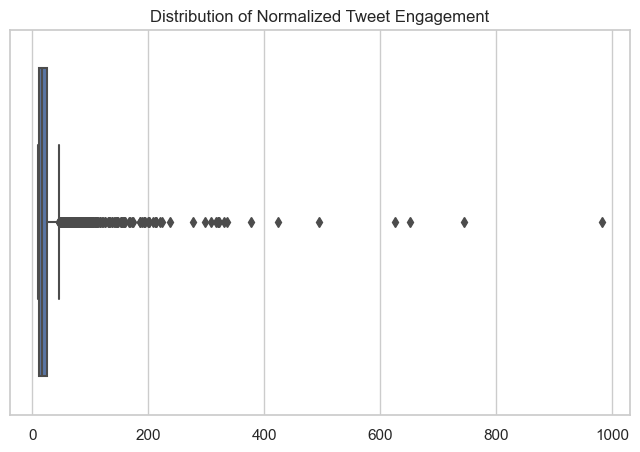

In [103]:
# plt.hist(merged_output_df3['sum_norm_engmnt'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_output_df3[merged_output_df3['sum_norm_engmnt'] > 10], x="sum_norm_engmnt")
plt.title('Distribution of Normalized Tweet Engagement')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [91]:
merged_output_df3.head()

,tweet_id,user,created_at,text,is_reply,source,lang,retweet_count,reply_count,like_count,...,num_topics,avg_user_retweets,avg_user_replies,avg_user_likes,avg_user_quotes,norm_eng_retweets,norm_eng_replies,norm_eng_likes,norm_eng_quotes,sum_norm_engmnt
0,1154670861376524289,easyJet,2019-07-26T08:32:40.000Z,It may take us a little longer to reply to you...,0.0,Sprinklr,en,2.0,28.0,11.0,...,17,10.908088,29.408088,93.856618,3.411765,0.183350,0.952119,0.117200,0.293103,1.545773
1,1154670731613081600,easyJet,2019-07-26T08:32:09.000Z,"Due to adverse weather across the UK, easyJet,...",0.0,Sprinklr,en,6.0,34.0,31.0,...,17,10.908088,29.408088,93.856618,3.411765,0.550051,1.156145,0.330291,1.172414,3.208900
2,1154424096123494400,easyJet,2019-07-25T16:12:07.000Z,RT @TLRailUK: ⚠️ #TLUpdates - Services between...,0.0,Sprinklr,en,6.0,0.0,0.0,...,17,10.908088,29.408088,93.856618,3.411765,0.550051,0.000000,0.000000,0.000000,0.550051
3,1154330542013386753,easyJet,2019-07-25T10:00:22.000Z,"⚠️ 🚗 🚧 Due to an accident on the M23, which is...",0.0,Sprinklr,en,4.0,7.0,10.0,...,17,10.908088,29.408088,93.856618,3.411765,0.366700,0.238030,0.106545,0.000000,0.711276
4,1154327194153508864,easyJet,2019-07-25T09:47:04.000Z,RT @HighwaysSEAST: As a result of this collisi...,0.0,Sprinklr,en,5.0,0.0,0.0,...,17,10.908088,29.408088,93.856618,3.411765,0.458375,0.000000,0.000000,0.000000,0.458375


### For the top keywords in each topic...

#### Get each keyword’s importance to the topic, and count how many topic tweets contain the keyword

In [128]:
topic_nums_to_names = {
    "0": "Charitable work, raising awareness",
    "2": "Future-forward campaigns (i.e. aviation, sustainability)",
    "3": "Travel spots with the best views",
    "4": "Campaign with a contest",
    "5": "Non-stop flight service",
    "6": "Promotional campaign via travel suggestions",
    "8": "Best/lowest/discounted fares",
    "10": "Airline growth (i.e. new routes, aircraft, offerings)",
    "11": "Scenic/peaceful travel destinations",
    "12": "Flight seating (i.e. group seating, upgrades)",
    "13": "Travel alerts and advisories",
    "14": "Visit our website for more info",
    "16": "Tips for comfortable travel experience"
}

In [127]:
lda_model_17.show_topic(0)

[('world', 0.19042131),
 ('learn', 0.097328134),
 ('come', 0.09181764),
 ('food', 0.073243886),
 ('team', 0.07082496),
 ('support', 0.06099797),
 ('help', 0.058327336),
 ('big', 0.055520546),
 ('proud', 0.042100627),
 ('want', 0.041373894)]

In [135]:
topic_nums = [int(i) for i in list(topic_nums_to_names.keys())]
topic_keywords_wgts = [lda_model_17.show_topic(tpc_num) for tpc_num in topic_nums]

In [146]:
df_topic_word_imp = []

for idx, topic in zip(topic_nums, topic_keywords_wgts):
    for keyword, wgt in topic:
        df_topic_word_imp.append([idx, keyword, wgt])

df_topic_word_importances = pd.DataFrame(
    df_topic_word_imp, columns=['topic_id', 'topic_keyword', 'keyword_importance']) 

In [147]:
df_topic_word_importances

,topic_id,topic_keyword,keyword_importance
0,0,world,0.190421
1,0,learn,0.097328
2,0,come,0.091818
3,0,food,0.073244
4,0,team,0.070825
...,...,...,...
125,16,baggage,0.057725
126,16,holiday,0.051044
127,16,begin,0.048341
128,16,update,0.043060


In [148]:
df_topic_word_importances['topic_id'].unique()

array([ 0,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13, 14, 16])

In [182]:
def get_topic_level_tweet_counts_and_tweet_median_engmts_per_keyword(row, topic_num):
    
    keyword = row['topic_keyword']
    
    # Get all tweets for that topic
    topic_tweets = merged_output_df3[merged_output_df3['Dominant_Topic'] == topic_num]
    # topic_tweets_with_keyword = topic_tweets[topic_tweets['lemma_tokens']]
    
    keyword_count_for_topic = 0
    keyword_tweet_engagements = []
    for i, twt_row in topic_tweets.iterrows():
        if keyword in twt_row['lemma_tokens']:
            keyword_count_for_topic += 1
            keyword_tweet_engagements.append(twt_row['sum_norm_engmnt'])
    
    return keyword_count_for_topic, np.median(keyword_tweet_engagements), keyword_count_for_topic / topic_tweets.shape[0]


all_dfs_topic_keywords = pd.DataFrame()

for topic_num in topic_nums:
    print(topic_num)
    topic_keywords = df_topic_word_importances[df_topic_word_importances['topic_id'] == topic_num]
    topic_keywords[['keyword_tweet_count_in_topic', 'median_engmt_of_tweets_w_keyword', 'share_of_topic_tweets']] = topic_keywords.apply(
        lambda row: pd.Series(
            get_topic_level_tweet_counts_and_tweet_median_engmts_per_keyword(row, topic_num)), axis=1)
    
    all_dfs_topic_keywords = pd.concat([all_dfs_topic_keywords, topic_keywords], ignore_index=True, axis=0)


0


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

2


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

3


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

4


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

5
6


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

8


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

10


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

11


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

12
13


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

14


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

16


/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xx/kxh7_3zx7bz9q034l1pmcfjh0000gn/T/ipykernel_27894/3873011658.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [183]:
all_dfs_topic_keywords['topic_name'] = all_dfs_topic_keywords.apply(
    lambda row: topic_nums_to_names[str(row['topic_id'])], axis=1)
all_dfs_topic_keywords

,topic_id,topic_keyword,keyword_importance,keyword_tweet_count_in_topic,median_engmt_of_tweets_w_keyword,share_of_topic_tweets,topic_name
0,0,world,0.190421,926.0,2.051217,0.210886,"Charitable work, raising awareness"
1,0,learn,0.097328,674.0,1.482734,0.153496,"Charitable work, raising awareness"
2,0,come,0.091818,698.0,2.131197,0.158962,"Charitable work, raising awareness"
3,0,food,0.073244,182.0,1.622486,0.041448,"Charitable work, raising awareness"
4,0,team,0.070825,550.0,1.837875,0.125256,"Charitable work, raising awareness"
...,...,...,...,...,...,...,...
125,16,baggage,0.057725,100.0,1.809497,0.045830,Tips for comfortable travel experience
126,16,holiday,0.051044,229.0,1.558140,0.104950,Tips for comfortable travel experience
127,16,begin,0.048341,109.0,1.983868,0.049954,Tips for comfortable travel experience
128,16,update,0.043060,291.0,1.122136,0.133364,Tips for comfortable travel experience


In [181]:
all_dfs_topic_keywords['median_engmt_of_tweets_w_keyword'].describe()

count    127.000000
mean       1.833225
std        0.525644
min        0.366700
25%        1.562576
50%        1.767624
75%        2.050392
max        3.952371
Name: median_engmt_of_tweets_w_keyword, dtype: float64

In [180]:
# all_dfs_topic_keywords.to_csv('all_dfs_topic_keywords.csv', index=False)

•	Goal: Visualize the top terms per topic across all airlines, by plotting each topic-term’s importance to the topic against the count of tweets in the topic that contain the term, using a bubble chart. A bubble’s color will represent an aggregated measure of user engagement with the tweet (i.e. number of likes, retweets, etc.) and a bubble’s size will represent the term’s frequency out of the top terms being visualized for the topic. 

- x: keyword_importance
- y: keyword_tweet_count_in_topic
- color: median_engmt_of_tweets_w_keyword
- size: share_of_topic_tweets (keyword_tweet_count_in_topic normalized by total number of tweets in topic)

In [201]:
topic_0 = all_dfs_topic_keywords[all_dfs_topic_keywords['topic_id']==0]

fig = go.Figure(data=[go.Scatter(
    x=topic_0['keyword_importance'].values.tolist(), 
    y=topic_0['keyword_tweet_count_in_topic'].values.tolist(),
    mode='markers',
    marker=dict(
        size=topic_0['share_of_topic_tweets'].values.tolist(),
        sizemode='area',
        sizeref=2.*max(topic_0['share_of_topic_tweets'].values.tolist())/(40.**2),
        sizemin=4
    ),
    text=topic_0['topic_keyword'].values.tolist(),
    textposition='bottom center',
    name=topic_0['topic_name'].values.tolist()[0]
)
])

fig.update_layout(
        margin=dict(t=15, 
                    b=0, 
                    l=20, 
                    r=0),
        yaxis=dict(title='Tweet Count'),
        xaxis=dict(title='Keyword Importance (to topic)'),
        legend=dict(itemsizing='constant',
                    title=dict(text='   <b>Topic</b>')),
    )    

fig.show()

In [205]:
scatter_list = []

for topic_num in all_dfs_topic_keywords['topic_id'].unique():
    
    df_topic_num = all_dfs_topic_keywords[all_dfs_topic_keywords['topic_id']==topic_num]
    
    scatter_obj = go.Scatter(
        x=df_topic_num['keyword_importance'].values.tolist(), 
        y=df_topic_num['keyword_tweet_count_in_topic'].values.tolist(),
        mode='markers+text',
        opacity=0.6,
        marker=dict(
            size=df_topic_num['share_of_topic_tweets'].values.tolist(),
            sizemode='area',
            sizeref=2.*max(df_topic_num['share_of_topic_tweets'].values.tolist())/(40.**2),
            sizemin=4
        ),
        text=df_topic_num['topic_keyword'].values.tolist(),
        textposition='bottom center',
        name=df_topic_num['topic_name'].values.tolist()[0]
    )
    
    scatter_list.append(scatter_obj)

In [206]:
scatter_list

[Scatter({
     'marker': {'size': [0.2108859029833751, 0.15349578683671145,
                         0.15896151218401275, 0.04144841721703484,
                         0.12525620587565475, 0.09519471646549761,
                         0.1503074470507857, 0.059895240264176725,
                         0.10475973582327489, 0.09724436347073559],
                'sizemin': 4,
                'sizemode': 'area',
                'sizeref': 0.00026360737872921884},
     'mode': 'markers+text',
     'name': 'Charitable work, raising awareness',
     'opacity': 0.6,
     'text': [world, learn, come, food, team, support, help, big, proud, want],
     'textposition': 'bottom center',
     'x': [0.19042131304740906, 0.09732813388109207, 0.09181763976812363,
           0.0732438862323761, 0.07082495838403702, 0.06099797040224075,
           0.058327335864305496, 0.055520545691251755, 0.04210062697529793,
           0.04137389361858368],
     'y': [926.0, 674.0, 698.0, 182.0, 550.0, 418.0, 660.0, 2

In [207]:
fig = go.Figure(data=scatter_list)

#     fig = go.Figure(data=[go.Scatter(
#         x=topic_0['keyword_importance'].values.tolist(), 
#         y=topic_0['keyword_tweet_count_in_topic'].values.tolist(),
#         mode='markers',
#         marker=dict(
#             size=topic_0['share_of_topic_tweets'].values.tolist(),
#             sizemode='area',
#             sizeref=2.*max(topic_0['share_of_topic_tweets'].values.tolist())/(40.**2),
#             sizemin=4
#         ),
#         text=topic_0['topic_keyword'].values.tolist(),
#         textposition='bottom center',
#         name=topic_0['topic_name'].values.tolist()[0]
#     )
#     ])

fig.update_layout(
        margin=dict(t=15, 
                    b=0, 
                    l=20, 
                    r=0),
        yaxis=dict(title='Tweet Count'),
        xaxis=dict(title='Keyword Importance (to topic)'),
        legend=dict(itemsizing='constant',
                    title=dict(text='   <b>Topic</b>')),
    )    

fig.show()

### Appendix 

In [2]:
def give_emoji_free_text(text):
    return emoji.get_emoji_regexp().sub(r'', text.decode('utf8'))

In [3]:
example_tweet = 'We hope everyone is enjoying their holiday season — we know this couple is! 🎁💍\nhttps://t.co/EzAVQp4LZj'

In [12]:
emoji.replace_emoji(example_tweet, '')

'We hope everyone is enjoying their holiday season — we know this couple is! \nhttps://t.co/EzAVQp4LZj'

In [44]:
full_df.iloc[0, :]['text']

'RT @delightdoodahs: Cracking @easyJet flight from @EDI_Airport to Berlin this morning #lettheholidaysbegin https://t.co/rJJNXu9RO7'

In [56]:
tweet = full_df.iloc[0, :]['text']
tweet

'RT @delightdoodahs: Cracking @easyJet flight from @EDI_Airport to Berlin this morning #lettheholidaysbegin https://t.co/rJJNXu9RO7'

In [57]:
# Removing emojis (not in project scope)
tweet = emoji.replace_emoji(tweet, '')
tweet

'RT @delightdoodahs: Cracking @easyJet flight from @EDI_Airport to Berlin this morning #lettheholidaysbegin https://t.co/rJJNXu9RO7'

In [58]:
# Removing link related text
link_related = [r'http', r'bit.ly/', r'pic.twitter']
for link_to_clean in link_related:
    tweet = re.sub(fr'{link_to_clean}\S+', '', tweet)
tweet = tweet.strip("[link]")

tweet

'RT @delightdoodahs: Cracking @easyJet flight from @EDI_Airport to Berlin this morning #lettheholidaysbegin '

In [59]:
# Removing retweet, mention, or hashtag related text
rt_mtn_hsh_related = [r'RT\s@', r'@', r'#']
for rt_mtn_hsh_to_clean in rt_mtn_hsh_related:
    tweet = re.sub(fr'({rt_mtn_hsh_to_clean}[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    
tweet

': Cracking  flight from  to Berlin this morning  '

In [60]:
# Remove punctuation
punctuation = '!”$%&\’()*+,-./:;<=>?[\\]^_`{|}~•@'
tweet = re.sub('[' + punctuation + ']+', ' ', tweet)
tweet

'  Cracking  flight from  to Berlin this morning  '

In [62]:
# Remove spaces and numbers
tweet = re.sub('\s+', ' ', tweet)
tweet = re.sub('([0-9]+)', '', tweet)
tweet = tweet.strip()

tweet

'Cracking flight from to Berlin this morning'

In [12]:
example_str = r'http'
fr'{example_str}\S+'

'http\\S+'

In [5]:
r'http\S+'

'http\\S+'

In [ ]:
# Source: https://pub.towardsai.net/tweet-topic-modeling-part-2-cleaning-and-preprocessing-tweets-e3a08a8b1770

def remove_links(tweet):
    """Takes a string and removes web links from it"""
    tweet = re.sub(r'http\S+', '', tweet)   # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet)  # remove bitly links
    tweet = tweet.strip('[link]')   # remove [links]
    tweet = re.sub(r'pic.twitter\S+','', tweet)
    return tweet

def remove_users(tweet):
    """Takes a string and removes retweet and @user information"""
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove re-tweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove tweeted at
    return tweet

def remove_hashtags(tweet):
    """Takes a string and removes any hash tags"""
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)  # remove hash tags
    return tweet

def remove_av(tweet):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    tweet = re.sub('VIDEO:', '', tweet)  # remove 'VIDEO:' from start of tweet
    tweet = re.sub('AUDIO:', '', tweet)  # remove 'AUDIO:' from start of tweet
    return tweet

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def preprocess_tweet(tweet, lem_and_token=False):
    """Main master function to clean tweets, stripping noisy characters, and tokenizing use lemmatization"""
    tweet = remove_users(tweet)
    tweet = remove_links(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_av(tweet)
    tweet = tweet.lower()  # lower case
    tweet = re.sub('[' + punctuation + ']+', ' ', tweet)  # strip punctuation
    tweet = re.sub('\s+', ' ', tweet)  # remove double spacing
    tweet = re.sub('([0-9]+)', '', tweet)  # remove numbers
    if lem_and_token:
        tweet_token_list = tokenize(tweet)  # apply lemmatization and tokenization
        tweet = ' '.join(tweet_token_list)
    return tweet

In [22]:
path_csv = "airline_tweets_csvs/AerLingus.csv.gz"
df = pd.read_csv(path_csv, low_memory=False)